<a href="https://colab.research.google.com/github/audrey-fontana/clusterizacao_clientes/blob/main/clusterizacao_clientes_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo de análise das métricas RFV de um e-commerce
###Clusterização de clientes

Uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing.

Agrupamento dos clientes em clusters com base em seu comportamento de compra, para permitir identificar padrões e características em comum entre os clientes.

A partir desses clusters, são gerados insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

### Sobre os dados

Os dados originais foram extraídos da fonte: https://www.kaggle.com/datasets/carrie1/ecommerce-data

Os dados fornecidos possuem informações de transações de compras de uma loja de e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de 540.000 transações.

###Bibliotecas e leitura dos dados

In [255]:
%%capture
%pip install sidetable

In [256]:
#Importando as bibliotecas
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

#Para ler os arquivos direto do drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [257]:
#Lendo o data set
df = pd.read_csv("/content/drive/MyDrive/Educação/DNC - Aulas/Datasets/data_ecommerce.csv", encoding='latin1')

###Análise exploratória dos dados

In [258]:
#Analizando o tamanho do dataset e suas features
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [259]:
#Analizando as informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [260]:
#Verificando porque a feature "InvoiceNo" é um objeto;
#Perceba que algumas invoices contém letras
df.InvoiceNo.sort_values()

,InvoiceNo
0,536365
1,536365
2,536365
3,536365
4,536365
...,...
540449,C581490
541541,C581499
541715,C581568
541716,C581569


In [261]:
#Verificando valores únicos de "Desciption" e "Country"
df[['Description','Country']].nunique()

,0
Description,4223
Country,38


<Axes: ylabel='Country'>

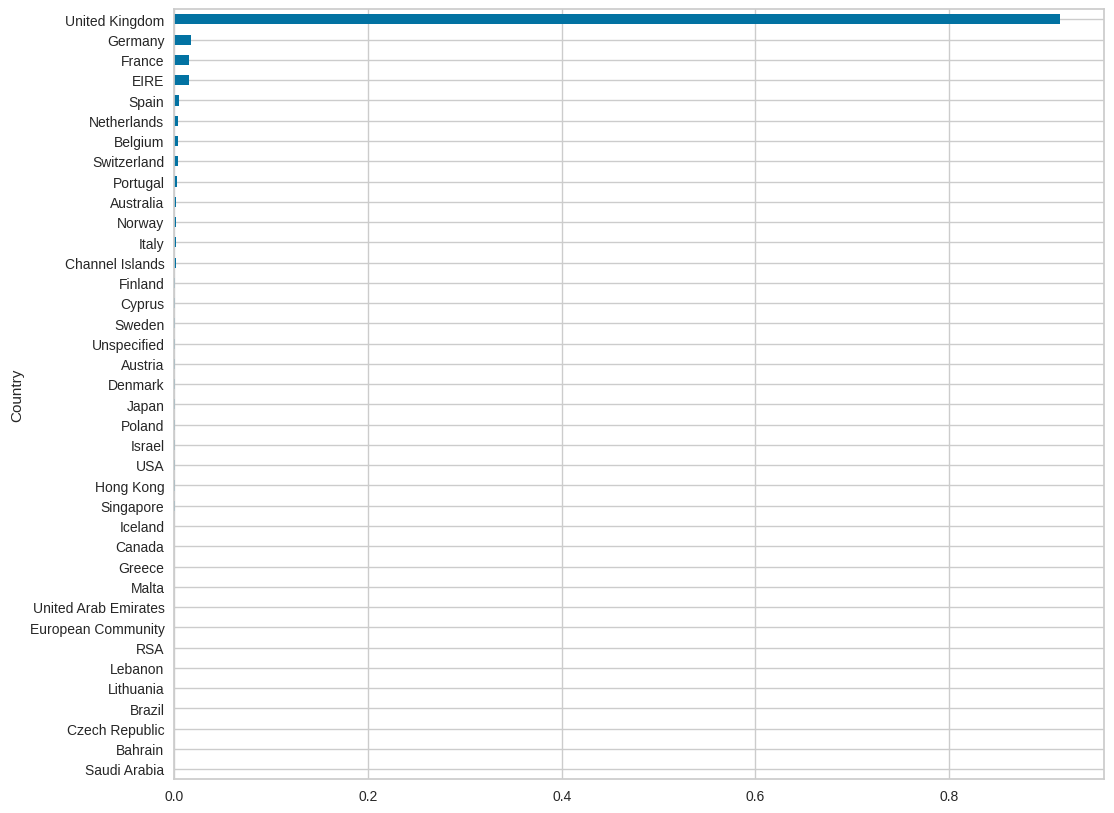

In [262]:
#Verificando a distribuição dos valores da variável "Country"
#Os dados foram normalizados para analizarmos em termos proporcionais
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [263]:
#Verificando as principais estatísticas da variável "Country"
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [264]:
#Verificando as principais estatísticas das variáveis numéricas
#Perceba que existem valores negativos que devem ser tratados
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [265]:
#Verificando a presença de valores faltantes no dataset
df.isna().sum().sort_values(ascending=False)

,0
CustomerID,135080
Description,1454
StockCode,0
InvoiceNo,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [266]:
#Utilizando a biblioteda sidetable para verificar os valores faltantes
#Como iremos clusterizar os clientes, não podemos ter "CustomerID" faltantes;
#24,9% do dataset contém "CustomerID" faltantes
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
StockCode,0,541909,0.000000
InvoiceNo,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [267]:
#Verificando a quantidade de valores duplicados no dataset
df.duplicated().sum()

np.int64(5268)

###Pré-processamento dos dados

In [268]:
#Exclusão dos dados faltantes na coluna de "CustomerID"
df = df.dropna(subset=['CustomerID'])

In [269]:
#Verificando se a exclusão ocorreu corretamente
#Com a limpeza dos dados de "CustomerID", a feature de "Description" também foi limpa e está sem valores faltantes
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [270]:
#Alterando o tipo de dado da coluna de "InvoiceDate"
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

/tmp/ipython-input-2774854292.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [271]:
#Alterando outros tipos de dados
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

/tmp/ipython-input-3789273606.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-3789273606.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [272]:
df = df.copy()
#Verificando se as alterações ocorreram corretamente
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


In [273]:
#Verificando os dias mín e máx dentro do dataset
df.InvoiceDate.agg(['min','max'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00


In [274]:
#Removendo os valores negativos das variáveis de "Quantity" e "UnitPrice"
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

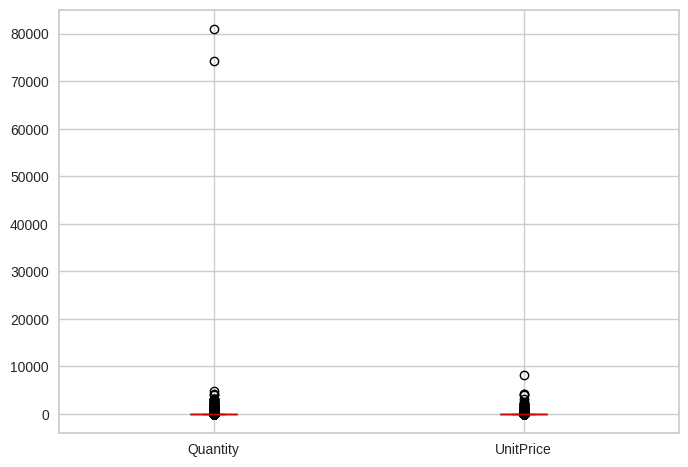

In [275]:
#verificando a remoção e presença de outliers;
#Existem dois outliers muito grandes, que precisam ser tratados
df[['Quantity','UnitPrice']].plot.box()

In [276]:
#Analizando os outliers de quantidade acima de 10.000
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


<Axes: >

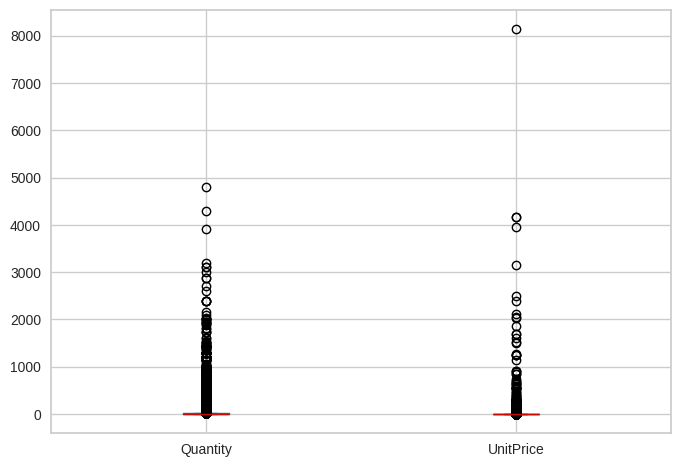

In [277]:
#Boxplot sem os outliers de quantidade acima de 10.000; para verificar a nova distribuição dos outliers
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [278]:
#Verificando o outlier de "UnitPrice" acima de 8.000
df.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [279]:
#Removendo os outliers extremos
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

In [280]:
#Criando uma coluna de preço total
df['price_total'] = df.Quantity * df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


####Cálculo de RFM

o RFM é a base analítica que permite que o marketing de um e-commerce seja estratégico, eficiente e personalizado.

**R **- Recência: há quantos dias o cliente fez a sua última compra;

Historicamente, a Recência (R) é um dos indicadores mais fortes do comportamento futuro de compra. Se um cliente comprou recentemente, ele provavelmente comprará novamente.

**F** - Frequência: a frequência que um cliente faz compra em um período específico

**M** - Valor monetário: o valor total que o cliente gastou com a empresa em um período específico



In [281]:
#Cálculo de RFM;
#Utilizamos uma data de refência de 01/01/2012 em função dos útlimos dados presentes no dataset
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


<Axes: >

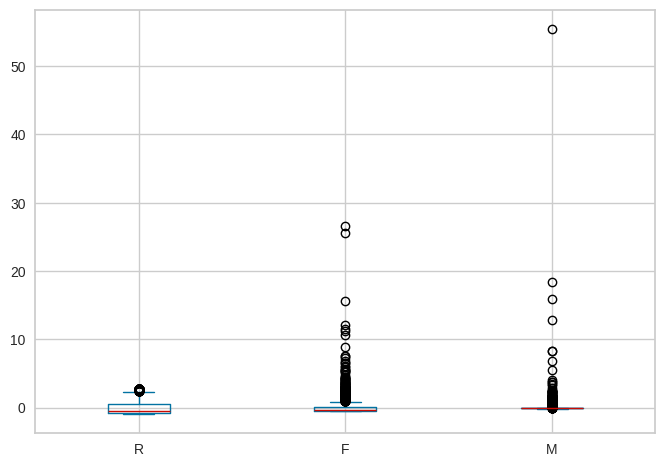

In [282]:
#Verificando a presença de outliers
df_rfm.apply(scale).plot.box()

In [283]:
#Verificando outlier extremo no M
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.899878,-0.165317,55.434876


In [284]:
#Analizando o cliente em questão
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [285]:
#Decisão de excluir esse cliente da análise
df_rfm = df_rfm.drop(15098)

<Axes: >

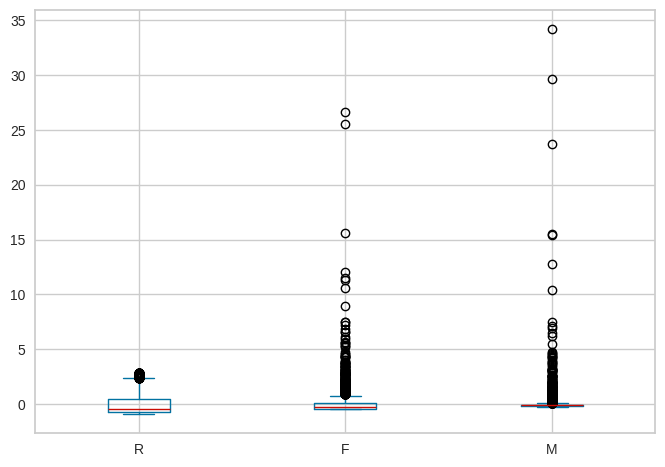

In [286]:
df_rfm.apply(scale).plot.box()

In [287]:
#Transformar dados para que sua distribuição seja mais próxima de uma distribuição Gaussiana (normal).
scaler = PowerTransformer()

In [288]:
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563219,1.201866,0.407836
12348,0.323470,0.660670,1.329304
12349,-0.809134,-1.158070,0.426829
12350,1.568467,-1.158070,0.189376
12352,-0.307718,1.309671,0.653411
...,...,...,...
18280,1.475652,-1.158070,0.085562
18281,1.107356,-1.158070,-0.491003
18282,-1.275046,-0.195707,-0.161007


<Axes: >

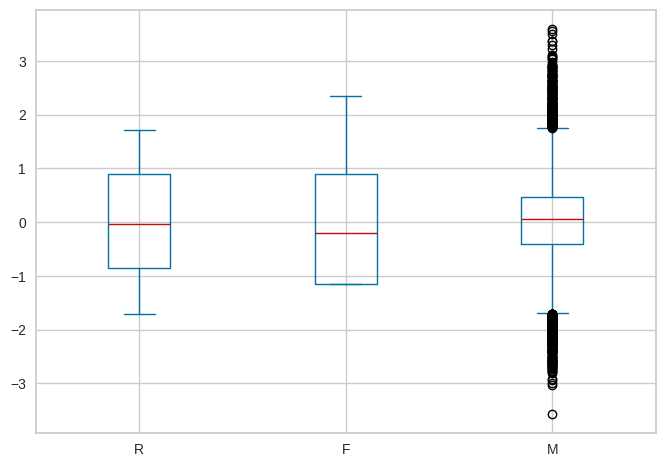

In [289]:
df_rfm_scaled.plot.box()

In [290]:
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.554185
std,99.968352,7.697927,129.202663
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,395.000000,209.000000,4453.430000


In [291]:
#Limitar ou atenuar o efeito de outliers extremos (valores muito altos) na análise de dados, sem remover as linhas.
#Ação: Todos os valores em cada coluna do df_rfm que forem superiores ao seu respectivo percentil 95 serão substituídos pelo valor desse percentil 95.
#Os valores abaixo ou iguais ao percentil 95 permanecem inalterados.
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


In [292]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

<Axes: >

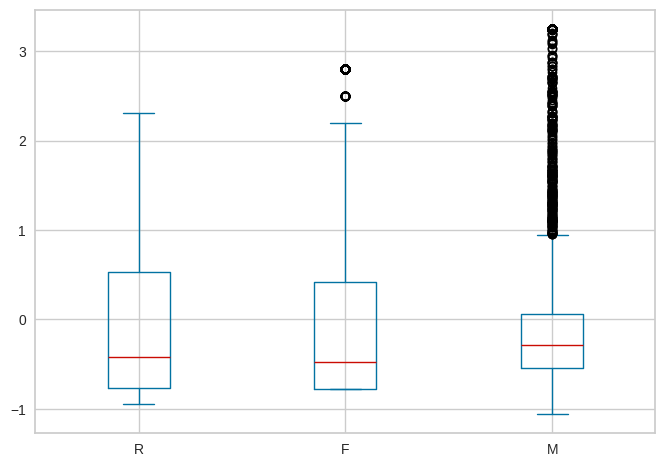

In [293]:
df_rfm_clip_scaled.plot.box()

###Seleção do algoritmo de clusterização

####K-Means

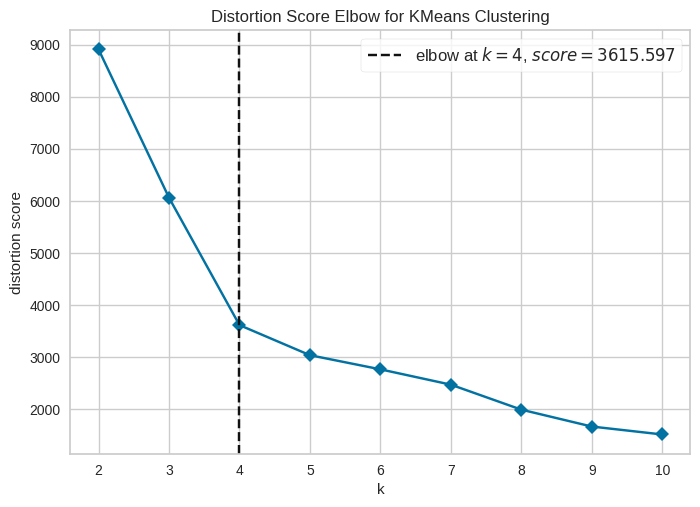

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [294]:
#Seleção da quantidade de cluster
#Método Elbow
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [295]:
#Verificando outras métricas para seleção de clusters

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9608.319042,0.481575,1.042550,1533.485432
3,6380.827963,0.395222,0.918987,2250.147145
4,3615.611638,0.479553,0.704462,3751.144746
5,3104.989759,0.386168,0.855067,3453.313624
6,2542.521220,0.397775,0.851237,3564.616053
7,2240.392476,0.401925,0.849436,3467.623360
8,1907.087195,0.383633,0.862005,3598.989252
9,1668.788329,0.394132,0.800834,3675.183274
10,1516.652722,0.351693,0.887890,3641.928356


In [296]:
#Escolha de 4 clusters
#Fit do modelo
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

In [297]:
#Visualização 3D
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

####Clustering hierárquico

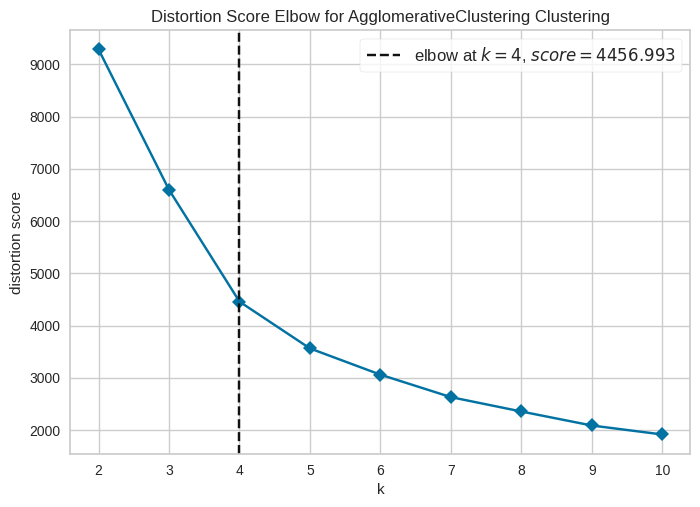

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [298]:
#Definição da quantidade de cluster pelo método kelbow
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [299]:
#Verificando outras métricas para seleção de clusters

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.361292,1.331666,1737.623791
3,0.398928,0.869855,2104.783905
4,0.431886,0.761966,2770.399918
5,0.342136,0.897329,2872.239315
6,0.348298,0.791909,2816.854970
7,0.322680,0.844326,2848.491623
8,0.287643,0.967432,2799.001327
9,0.286883,0.976982,2832.797336
10,0.298923,0.953087,2786.657350


In [300]:
#Escolha de 4 clusters
#Fit do modelo
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [301]:
#Visualização 3D
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

####Gaussian Mixture

In [302]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
28,-42.948733,8,full
30,-7.576575,8,diag
26,212.991984,7,diag
24,2078.032685,7,full
20,9370.688268,6,full


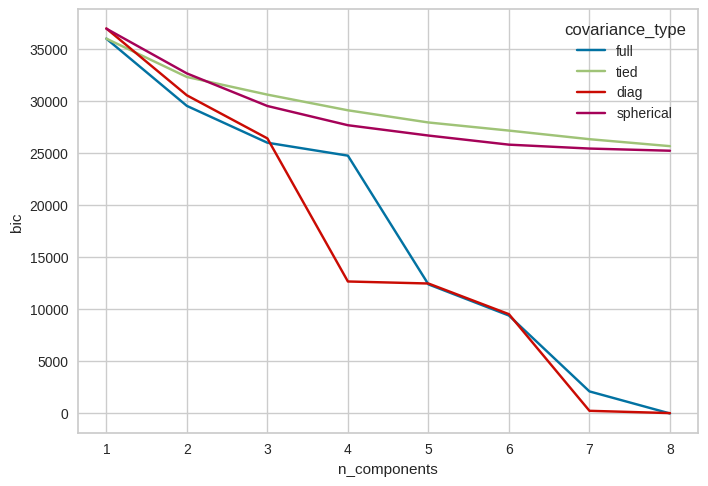

In [303]:
#analizando graficamente os tipos de covariância e nº de clusters
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [304]:
#Fit do modelo; cluster = 5; tipo de covariância = full
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [305]:
#Visualização 3D
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

####DBSCAM

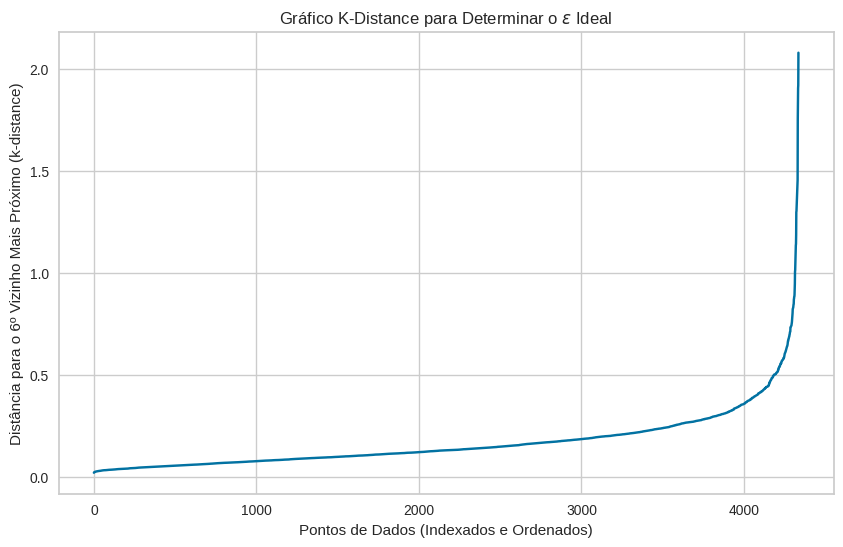

In [315]:
#Transformação Logarítmica (log(x+1))
rfm_log = df_rfm[['R', 'F', 'M']].apply(lambda x: np.log(x + 1))

#Escalonamento dos dados transformados
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

#Método K-Distance para encontrar o eps ideal
min_samples = 6 # Valor recomendado: 2 * 3 dimensões
k = min_samples - 1 # k = 5

#Encontrar a distância para o k-ésimo vizinho mais próximo
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

#Pegar as distâncias para o k-ésimo vizinho (última coluna) e ordenar
k_distances = np.sort(distances[:, k-1], axis=0)

#Plotar o gráfico de k-distance
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Pontos de Dados (Indexados e Ordenados)")
plt.ylabel(f"Distância para o {k+1}º Vizinho Mais Próximo (k-distance)")
plt.title("Gráfico K-Distance para Determinar o $\\epsilon$ Ideal")
plt.grid(True)

In [316]:
#REPARAR PARA DBSCAN: ESCALONAMENTO
rfm_scaled = scaler.fit_transform(df_rfm_clip_scaled)

In [317]:
#APLICAR DBSCAN
#Parâmetros:
#eps: Distância máxima entre duas amostras para uma ser considerada no bairro da outra.
#min_samples: Número de amostras em um bairro para que um ponto seja considerado um ponto central.
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_rfm['Cluster'] = dbscan.fit_predict(rfm_scaled)

In [318]:
#ANÁLISE E SAÍDA
#Contagem de clientes por cluster
cluster_counts = df_rfm['Cluster'].value_counts().sort_index()
print("\nTamanho dos Clusters DBSCAN:")
print(cluster_counts)
print("\nNota: O cluster -1 representa 'outliers' (pontos de ruído).")


Tamanho dos Clusters DBSCAN:
Cluster
-1      27
 0    4309
Name: count, dtype: int64

Nota: O cluster -1 representa 'outliers' (pontos de ruído).


###Análise dos clusters obtidos
---

O melhor resultado obtivo foi com a clusterização via k-means, onde os clientes foram divididos em 4 grupos.


In [306]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

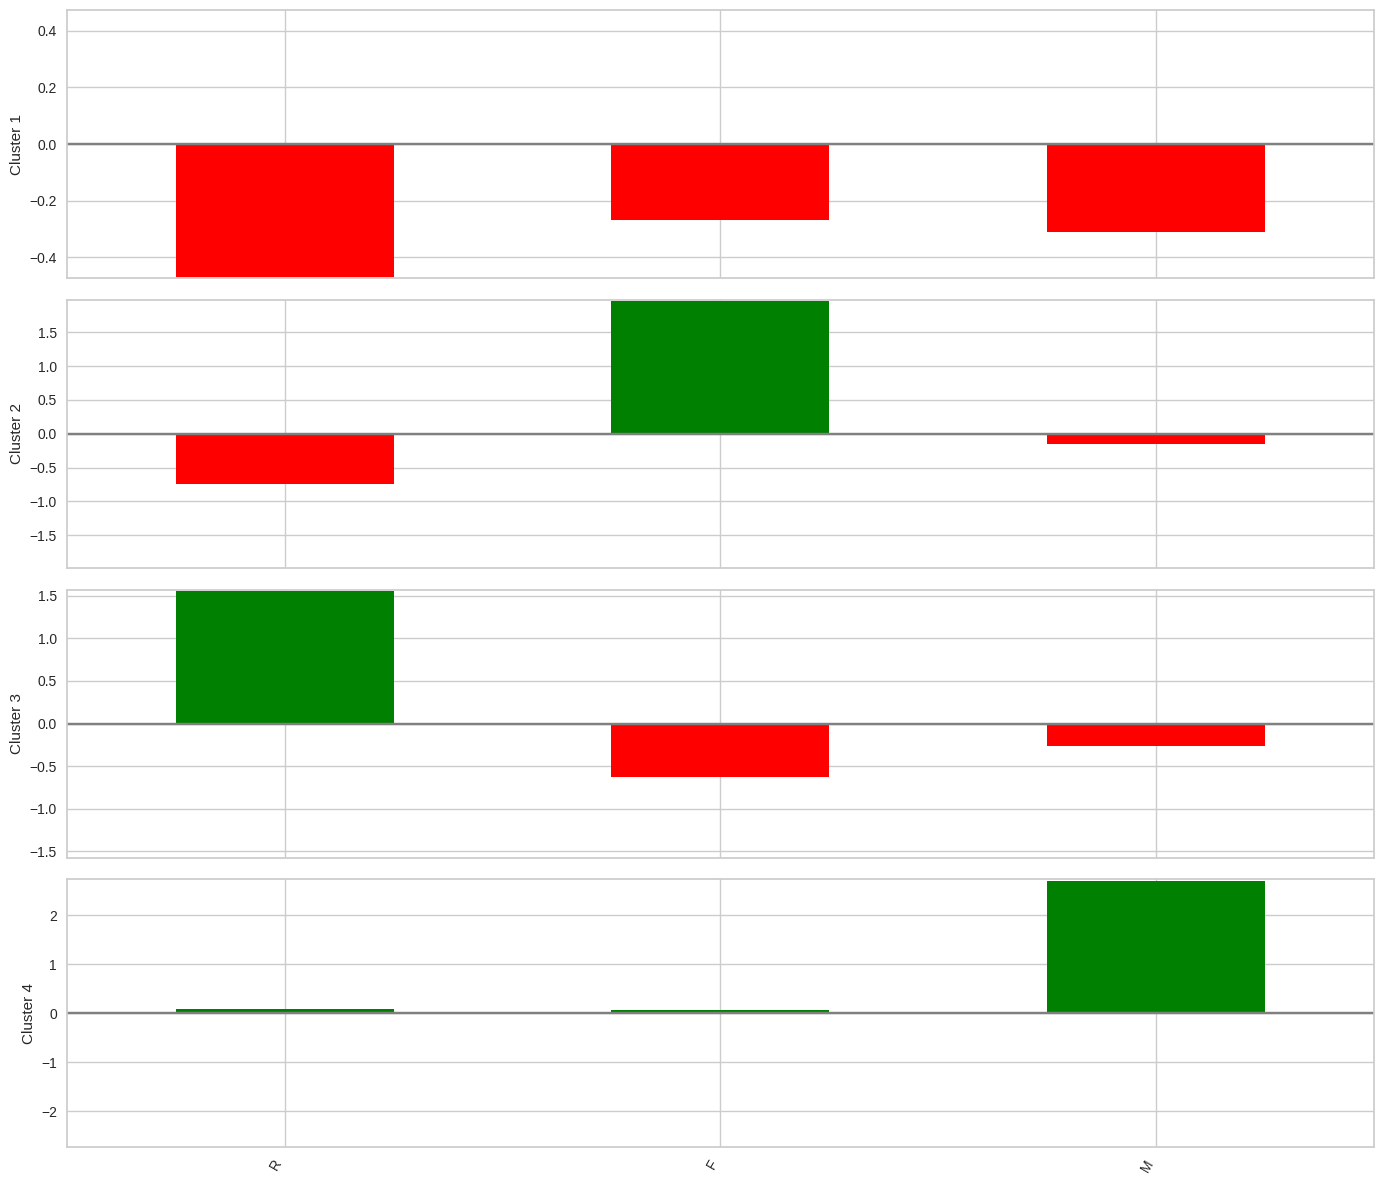

In [307]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [308]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,67.526002,41.517018,261.201439,121.317500
F,2.703751,10.191248,1.509764,3.862500
M,17.106104,20.426973,18.033822,80.496497


###Interpretação dos resultados obtidos

Analisando a tabela acima, podemos inferir as seguintes caracteristicas para os grupos:

Grupo 0: Clientes novos/potenciais:
* Recência baixa: compraram há pouco tempo;
* Frequência baixa: compraram poucas vezes;
* Valor gasto baixo;
* Estratégia: Foco no Onboarding e Cross-selling para aumentar a Frequência e o Valor.

Grupo 1: Clientes fiéis:
* Recência baixa: compraram há pouco tempo (menor recência de todas);
* Frequência alta: compram várias vezes (maior frequência de todas);
* Valor gasto médio;
* Estratégia: Manter o engajamento através de campanhas personalizadas e promoções baseadas em seus históricos de compra

Grupo 2: Clientes em risco/perdidos (pior segmento):
* Recência alta: compraram há muito tempo;
* Frequência baixa: compraram poucas vezes;
* Valor gasto baixo;
* Estratégia: Campanhas de reengajamento urgentes (win-back), descontos agressivos ou ofertas de valor para tentar trazê-los de volta.

Grupo 3: Clientes campeões:
* Recência média: compraram há algum tempo;
* Frequência média: compraram algumas vezes;
* Valor gasto: muito alto; são os clientes que geram maior receita.
* Estratégia: Recompensar, criar programas de fidelidade exclusivos e lançar novos produtos para eles primeiro.
